In [2]:
# Loading libraries

import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
import pmdarima as pm
from pmdarima import preprocessing as ppc
from pmdarima.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.ticker as tkr
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")



In [3]:
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
data.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [5]:
#Check %of missing values

data.isnull().sum() * 100 / len(data)

Month          0.0
#Passengers    0.0
dtype: float64

There are no missing values so we can proceed

Make our series datetime and specify datetime as index. Important when we are working on a timeseries analysis.

In [6]:
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# EDA and Violinplot for Months performance

In [7]:
# Prepare the Dataframe for the analysis and extract month from each date
# Create a new column which extracts the month for each date

data_analysis = data.reset_index()
data_analysis['Month'] = data_analysis['Date'].dt.month

data_analysis

,Date,Passengers,Month
0,1949-01-01,112,1
1,1949-02-01,118,2
2,1949-03-01,132,3
3,1949-04-01,129,4
4,1949-05-01,121,5
...,...,...,...
139,1960-08-01,606,8
140,1960-09-01,508,9
141,1960-10-01,461,10
142,1960-11-01,390,11


In [8]:
# Replace numerical values with Month Names


data_analysis['Month']=data_analysis['Month'].replace(to_replace =[1,2,3,4,5,6,7,8,9,10,11,12],  
value =["January","February","March","April","May","June","July","August","September","October","November","December"])

In [10]:
# Create violinplots in order to examin the montlhy passengers distribution

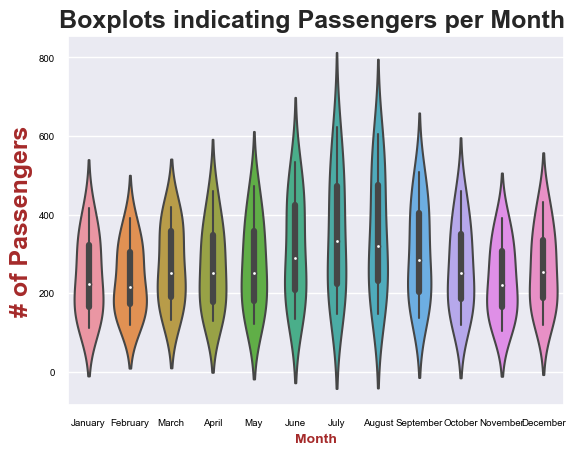

In [11]:
ax=sns.violinplot(data = data_analysis, y = 'Passengers', x = 'Month')
ax.set_title('Boxplots indicating Passengers per Month ',fontweight="bold",fontsize=18)
ax.set_ylabel('# of Passengers',fontweight="bold",fontsize=18,color="brown")
ax.set_xlabel("Month",fontweight="bold",fontsize=10,color="brown")
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
plt.xticks(fontsize=7,color="black")
plt.yticks(fontsize=7,color="black")
plt.show()

Violinplots is a very powerful graph combining a lot of information in only one plot.

The center white dot shows the mean values for each month. Additionally, we can examine the distribution for each month as well as if there are any extreme outliers.

From the above plot, we observe -as expected- that the summer months (June, July, August) have the highest average number of passengers including also some extreme values. November and February have the lowest mean values and the shortest violins, meaning that there are no great differences in number of passengers inside the month.

# Series Decomposition

After decomposing the series into trend, seasonal and residual components we can analyse it better. More specifically, we have chosen multiplicative model because there is a multiplicative increasing trend. We observe that there is a strong increasing trend with also very strong seasonality. So we understand that we should create a model that would include also the seasonal effect.

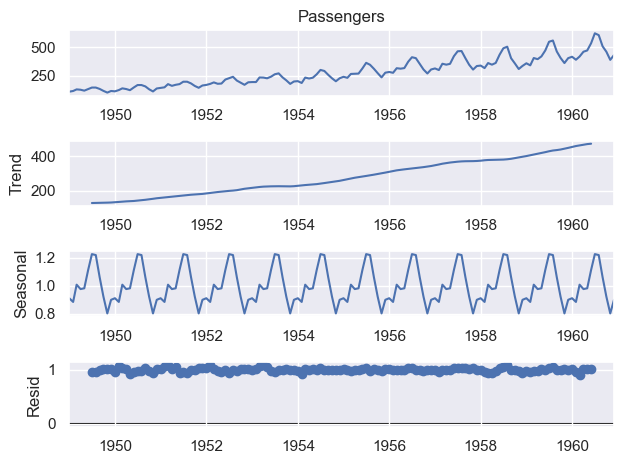

In [12]:
dec = sm.tsa.seasonal_decompose(data['Passengers'],period = 12, model = 'multiplicative').plot()
plt.show()

# Check Stationarity (Plot and Dickey-Fuller Test)

In order a timeseires to be more easily forecasted, it should be stationary. In order a series to be stationary it should not be time dependent and it should have steady mean and std. Also the Dickey-Fuller Test shows all the necessary values in order to judge whether or not we have a stationary series.

In [14]:
# Function for Stationarity
# Plot and Dickey-Fuller Test

def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

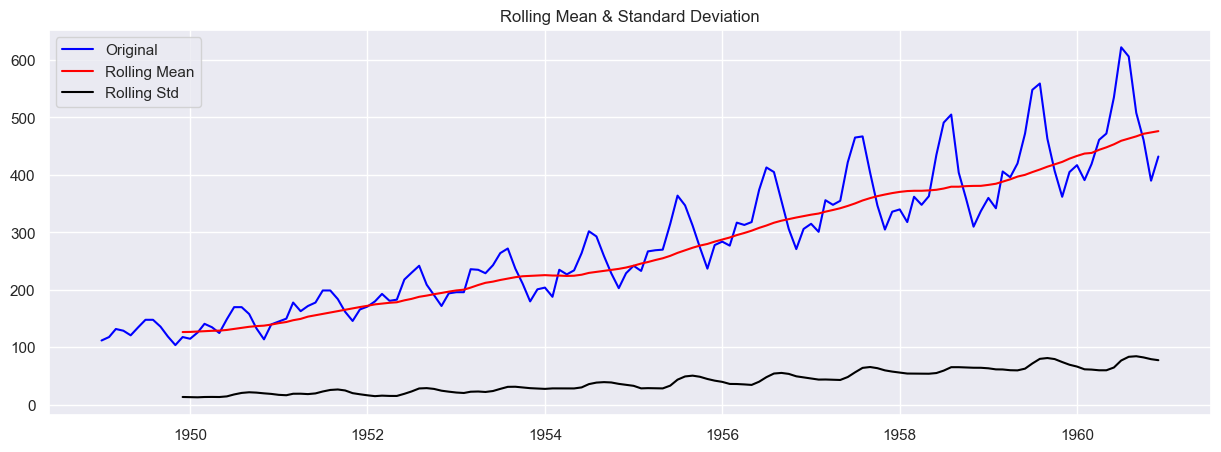

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
# Use function

test_stationarity(data['Passengers'])

It is clearly observed that we do not have a stationary series.

1) Mean and std are not constant over time

2) p-value> 0.05

3) Test Statistic > all Critical values

Thus we don't have a stationary series

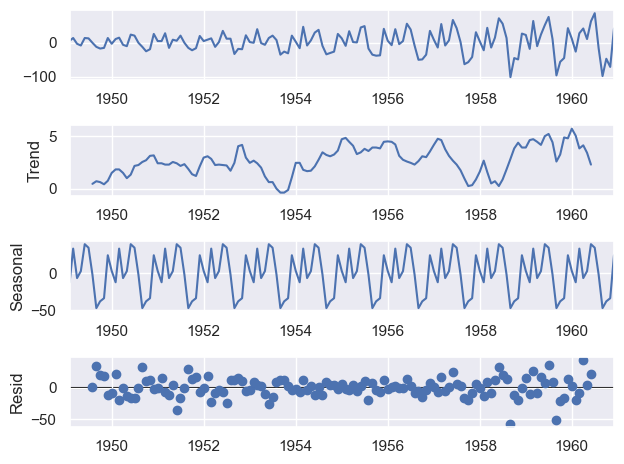

In [16]:
# Take difference in order to create a stationary series

data_diff = data.diff()
data_diff = data_diff.dropna()


#Plot again the decomposition to check the diffenced series
dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

After decomposing again the differenced series we see that there is not a specific trend and of course the seasonality aspect remains. Also the residuals are distributed around 0. Let's make use again of the stationarity test in order to examine the plots and the results from Dickey Fuller test.

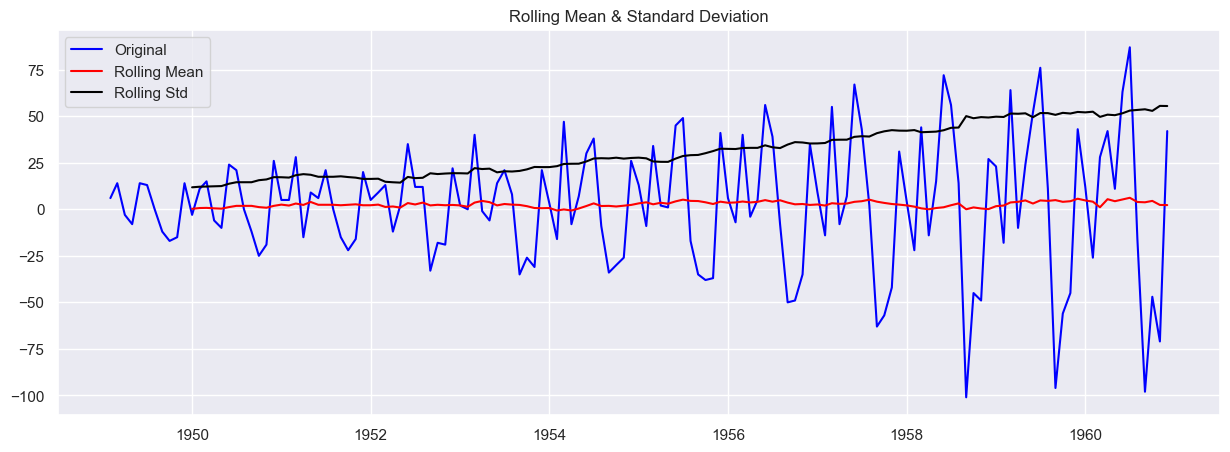

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [17]:
test_stationarity(data_diff)

After differencing with previous month we see that:

Rolling Mean is very close to 0 with a slight increase trend.

Rolling Standard Deviation displays a slight uptrend over time.

Test Statistic : (-2.83) > Critical Value (5%) : (-2.88).

p-value (0.05) > 0.05

Our series is very close to stationary and in fact we can say it is stationary in 90% confidence interval because T Statistic < Critical Value(10%). Despite it fails the stationarity test in confidence interval 95% we will use this series because by double-differencing our series would be too heavy on the data and might result in poor performance.

# Create first Naive Model (what happened yesterday will happen tomorrow)

In [18]:
#Build a Naive Baseline Model (what happened yesterday will happen tomorrow)

naive_model=data
naive_model=pd.concat([naive_model,naive_model.shift(1)],axis=1)
naive_model.columns=["Actual Passengers","Predicted Passengers"]
naive_model.dropna(inplace=True)

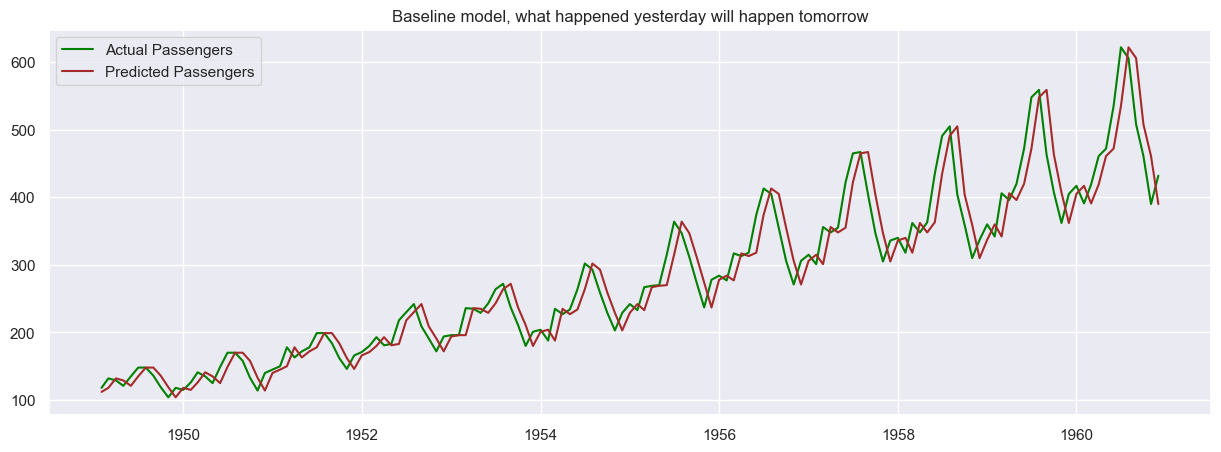

In [19]:
#Plot rolling statistics:
    
plt.figure(figsize=(15,5))
plt.plot(naive_model["Actual Passengers"], color='green',label='Actual Passengers')
plt.plot(naive_model["Predicted Passengers"], color='brown', label='Predicted Passengers')

plt.legend(loc='best')
plt.title('Baseline model, what happened yesterday will happen tomorrow')
plt.show(block=False)

In [20]:
# Check MSE for this first model
base_error=mean_squared_error(naive_model["Actual Passengers"],naive_model["Predicted Passengers"])
np.sqrt(base_error)

33.710408012832005

# Building ARIMA Model

In order to fit an ARIMA model we should find the parameters: p, d and q.

Previously in order to make our series stationary, we took the difference with previous day, so we have d = 1

So, we have to select the remaining components p and q.

We will do it by generating and examining the ACF and PACF plots and the significance of the time lags.

# Selecting Parameters p and q through ACF and PACF plots

Let's generate the plots.

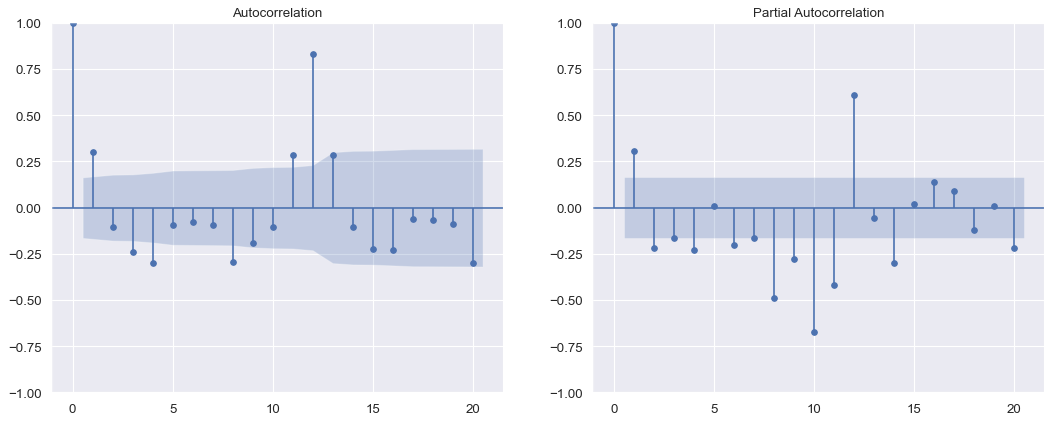

In [21]:
# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(data_diff, ax=ax1, lags=20)
plot_pacf(data_diff, ax=ax2, lags=20)

# Decorate
# lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

# Examining ACF plot 

ACF indicates series both direct and indirect autocorrelation time lags. From the ACF plots we detrmine the parameter P of an Arima model. Specifically from the above plot in our case we see that only the first lag of time falls outside the confidence interval. Thus we will select q=1. We see also that there are some very strong correlations for lag 12 (remember we have yearly data). So we can use also 12 as parameter.

# Examining PACF plot

PACF indicates series direct autocorrelation time lags after removing the indirect effects between lags. From PACF plot we detrmine the parameter p of an Arima model and we see that after excluding first lag, the two first lag of time (and slightly the second) fall outside the confidence interval. Thus we will select p=1 or p=2. Again here we have also some very strong correlations in the 12th lag of time.

# Split Dataset into training and test

<function matplotlib.pyplot.show(close=None, block=None)>

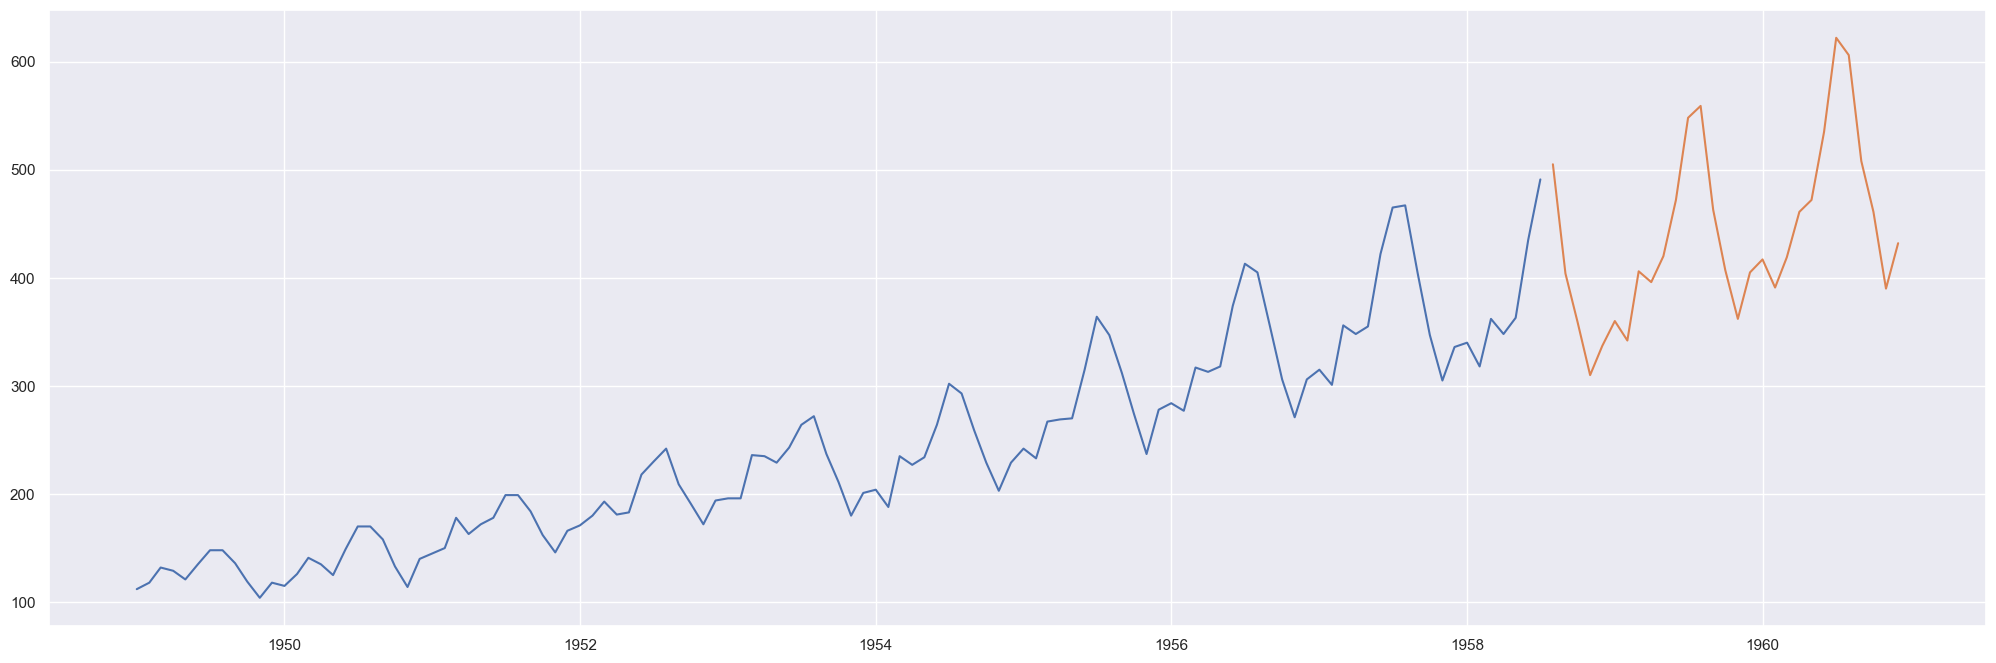

In [22]:
train_ts = data[0:115]
test_ts = data[115:]


# Creat timeseries plot


plt.figure(figsize=(25,8))
plt.plot(train_ts)
plt.plot(test_ts)
plt.show

In [23]:
train_ts["Passengers"]


Date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1958-03-01    362
1958-04-01    348
1958-05-01    363
1958-06-01    435
1958-07-01    491
Name: Passengers, Length: 115, dtype: int64

In [24]:
test_ts["Passengers"]

Date
1958-08-01    505
1958-09-01    404
1958-10-01    359
1958-11-01    310
1958-12-01    337
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
1959-05-01    420
1959-06-01    472
1959-07-01    548
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, dtype: int64

# 1st Arima Model with values from plots

In [25]:
# Building 1st ARIMA Model

ar = pm.arima.ARIMA(order=(2,1,1))
ar.fit(train_ts)

ARIMA(order=(2, 1, 1))

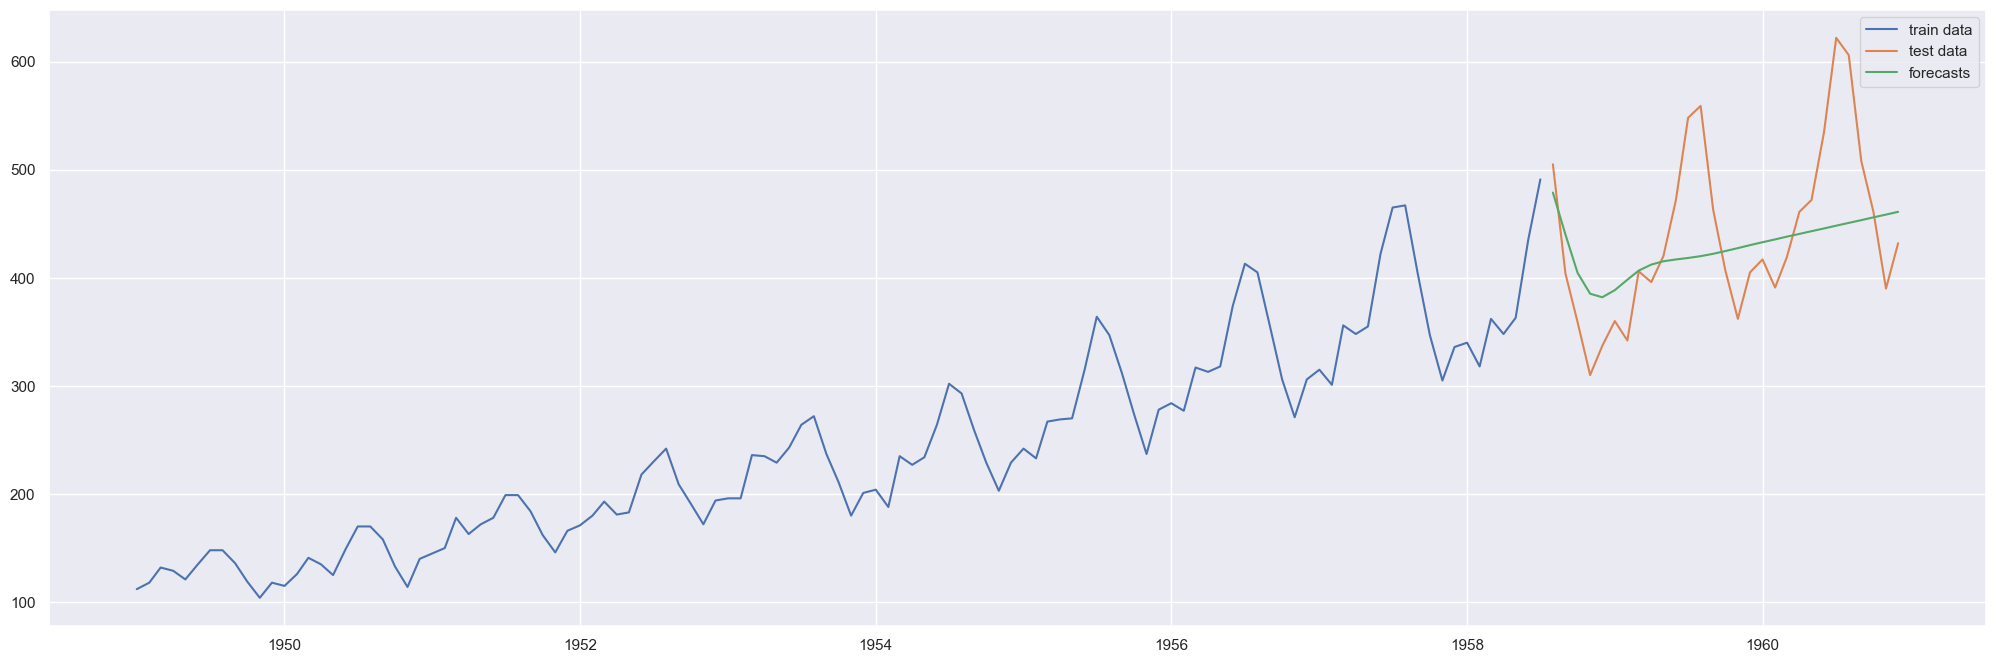

In [26]:
# Inspect Predictions

y_pred = pd.DataFrame(ar.predict(n_periods=30), index=test_ts.index, columns=['pred'])
plt.figure(figsize=(25,8))
plt.plot(train_ts, label='train data')
plt.plot(test_ts, label='test data')
plt.plot(y_pred, label='forecasts')
plt.legend()
plt.show()

We see that our predictions captures the trend however are far from reality because they cannot capture the seasonal component. Let's try to incorporate the seasonal component through the p and q parameter by inserting 12. Remember that we saw some very strong correlations in the 12th lag of time because we have yearly data.

In [27]:
print(f'mean absolute error: {round(mean_absolute_error(test_ts, y_pred), 2)} \n')

mean absolute error: 52.13 



# 2nd Model Incorporating Seasonality in p through simple AR model

In [28]:
# Building 1st ARIMA Model

ar1 = pm.arima.ARIMA(order=(12,0,0))
ar1.fit(train_ts)

ARIMA(order=(12, 0, 0))

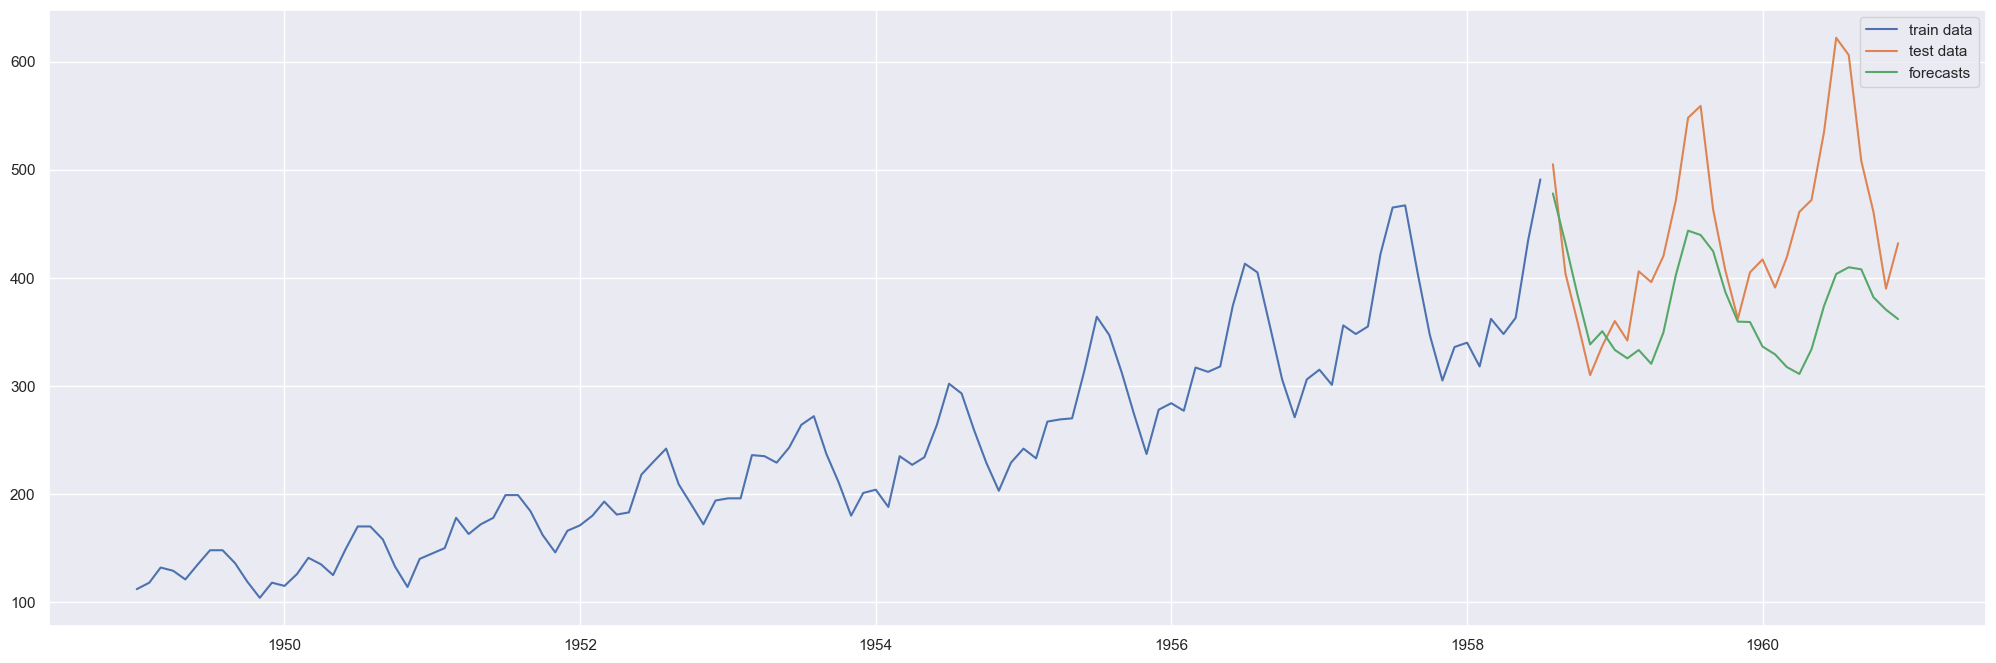

In [29]:
# Inspect Predictions

y_pred1 = pd.DataFrame(ar1.predict(n_periods=30), index=test_ts.index, columns=['pred'])
plt.figure(figsize=(25,8))
plt.plot(train_ts, label='train data')
plt.plot(test_ts, label='test data')
plt.plot(y_pred1, label='forecasts')
plt.legend()
plt.show()


Here we have plot a simple AR model, without differencing by ommiting the moving average part. We have incorporated only the seasonal component indicating with p=12 that the series is highly correlated with the previous 12th lag og time.

However, we have not captured the trend so there is still room for improvement for our model.

So, we will try to incorporate also the differencing and the seasonality in parameter q.

In [30]:
print(f'mean absolute error: {round(mean_absolute_error(test_ts, y_pred1), 2)} \n')

mean absolute error: 74.5 



# 3rd Model Incorporating Seasonality in p and q and also including differencing.

In [31]:
ar2 = pm.arima.ARIMA(order=(12,1,12))
ar2.fit(train_ts)

ARIMA(order=(12, 1, 12))

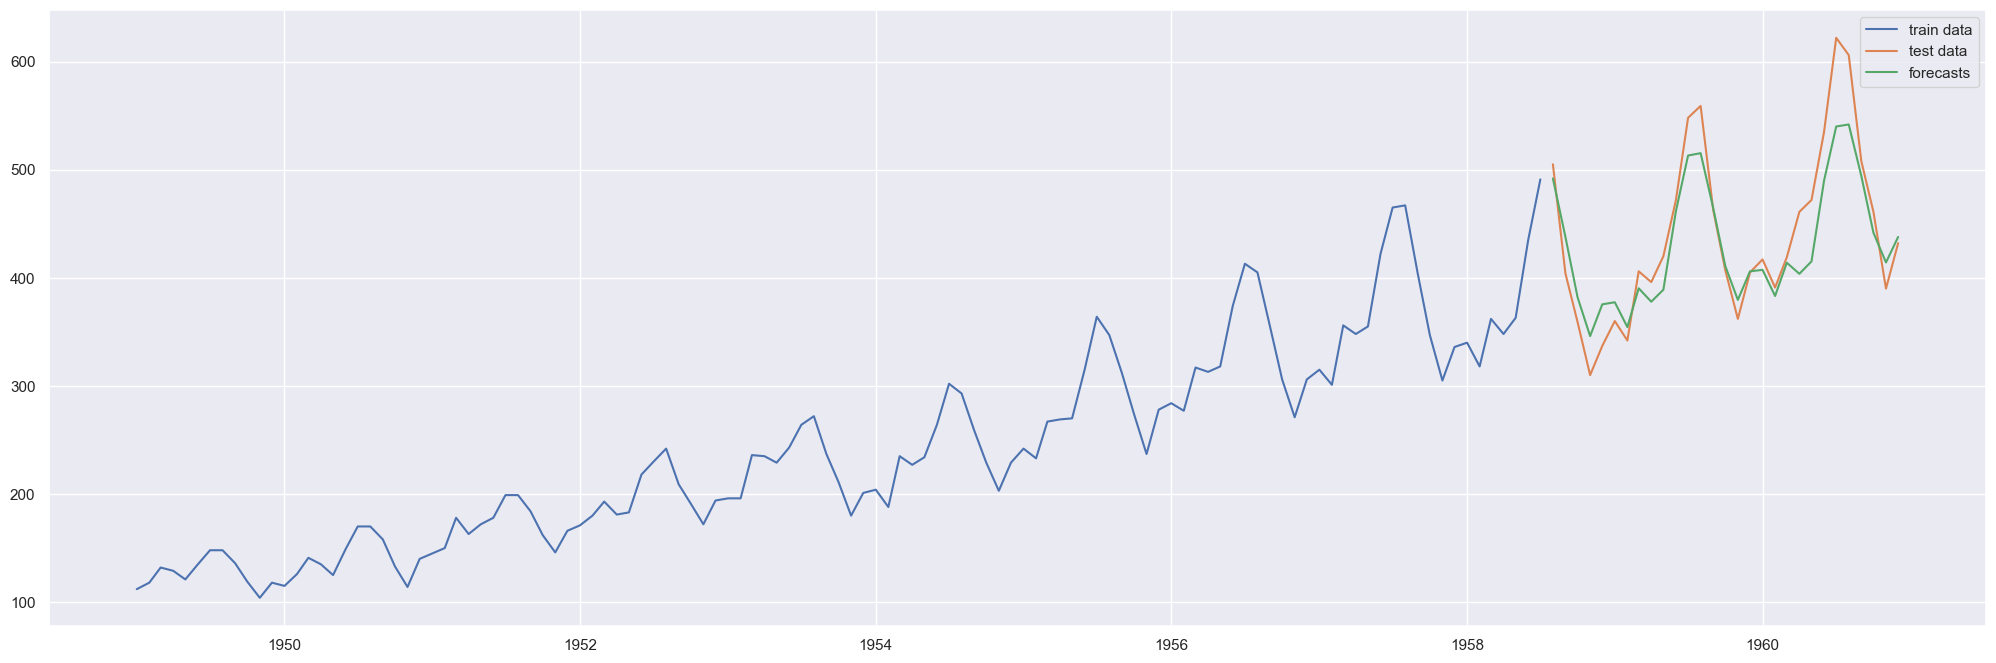

In [32]:
# Inspect Predictions

y_pred2 = pd.DataFrame(ar2.predict(n_periods=30), index=test_ts.index, columns=['pred'])
plt.figure(figsize=(25,8))
plt.plot(train_ts, label='train data')
plt.plot(test_ts, label='test data')
plt.plot(y_pred2, label='forecasts')
plt.legend()
plt.show()

In [33]:
print(f'mean absolute error: {round(mean_absolute_error(test_ts, y_pred2), 2)} \n')

mean absolute error: 25.61 



After including the seasonal cycle of our series in both p and q and by also including the differencing componentn to make our series staionary we have a far more accurate results. From the Mean Absolute error we understand also that we have achieved a more accurate model. Can we perform better?

# 4th Model - Using SARIMA through Autoarima

Knowing all the concepts behind stationarity and being able to examine the ACF and PACF plots are the key parts in evry timeseries problem. Being able to select the parameters through your own EDA means that you understand the way timeseries behave.

After reaching the point where you can understand all this by yourself you can be introdued to the autorima python libary. Auto_arima is a very powerful python library which after fitting several models with different parameters it generates and keeps the best model with lowest AIC.

Auto_arima is fitted with the below way

In [34]:
# Fit stepwise auto-ARIMA with seasonal order 
model = pm.auto_arima(train_ts, start_p=1, start_q=1, max_p=12, max_q=12, # start and end p and q
                      test = 'adf', # use adftest to find optimal 'd'
                      seasonal=True, # We have Seasonality
                      d=None, D=None,  # let model determine 'd' we have used 1, let's see if it is the same
                      trace=True, m=12,   # trace to keep record of scores, m ->frequency of series (yearly)
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=758.260, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.750, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.380, Time=0.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=755.499, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.982, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.649, Time=0.18 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=756.771, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=756.022, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=756.011, Time=0.05 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=757.976, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=757.438, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.571 seconds


In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -375.750
Date:                            Sat, 16 Sep 2023   AIC                            755.499
Time:                                    00:50:49   BIC                            760.749
Sample:                                01-01-1949   HQIC                           757.625
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2048      0.090     -2.271      0.023      -0.382      -0.028
sigma2        92.6974     13.326      6.956      0.000      66.579     118.816
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.87   Prob(JB):                         0.30
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Autoarima has selected a SARIMA model, meaning a Seasonal ARIMA with best (1,1,0)x(0,1,0,12).

The first components are p=1 d=1 q=0 which were close to the one that we had selected(2,1,1). The second parantheseis are the Seasonal components and the last element 12, indicates the seasonal cycle (yearly data=12)

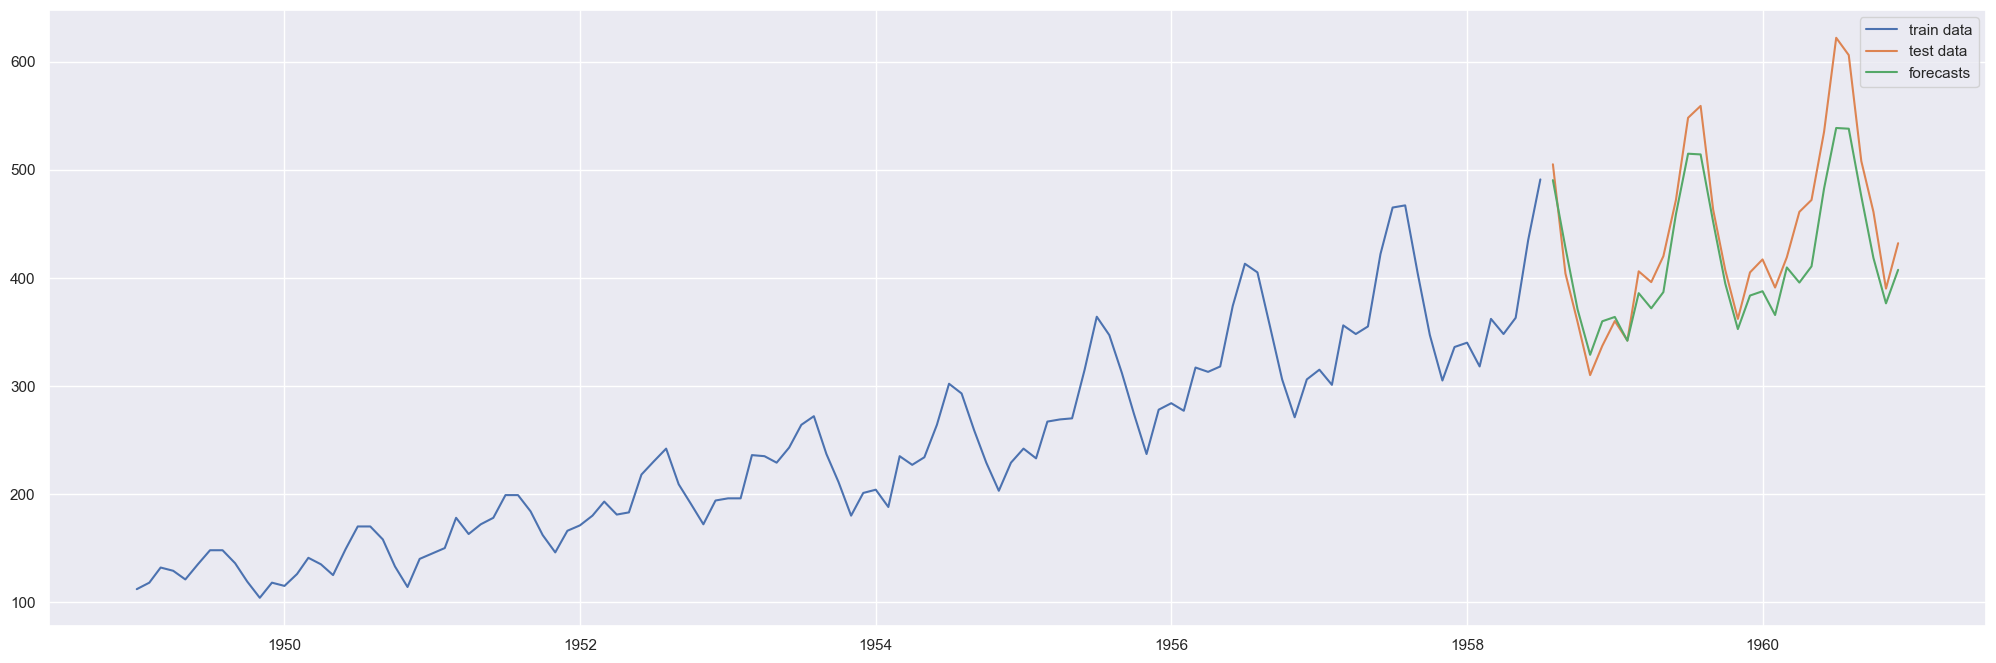

In [36]:
# Inspect Predictions

y_pred3 = pd.DataFrame(model.predict(n_periods=30), index=test_ts.index, columns=['pred'])
plt.figure(figsize=(25,8))
plt.plot(train_ts, label='train data')
plt.plot(test_ts, label='test data')
plt.plot(y_pred3, label='forecasts')
plt.legend()
plt.show()


In [37]:
print(f'mean absolute error: {round(mean_absolute_error(test_ts, y_pred3), 2)} \n')

mean absolute error: 28.55 



We observe that now we have even better model performance and more accurate predictions. Autoarima has selected the best parameters for us and fitted the best model. We see also that Mean absolute error has also decreased! Let's generate model summary in order to examine the selected model from Autoarima.

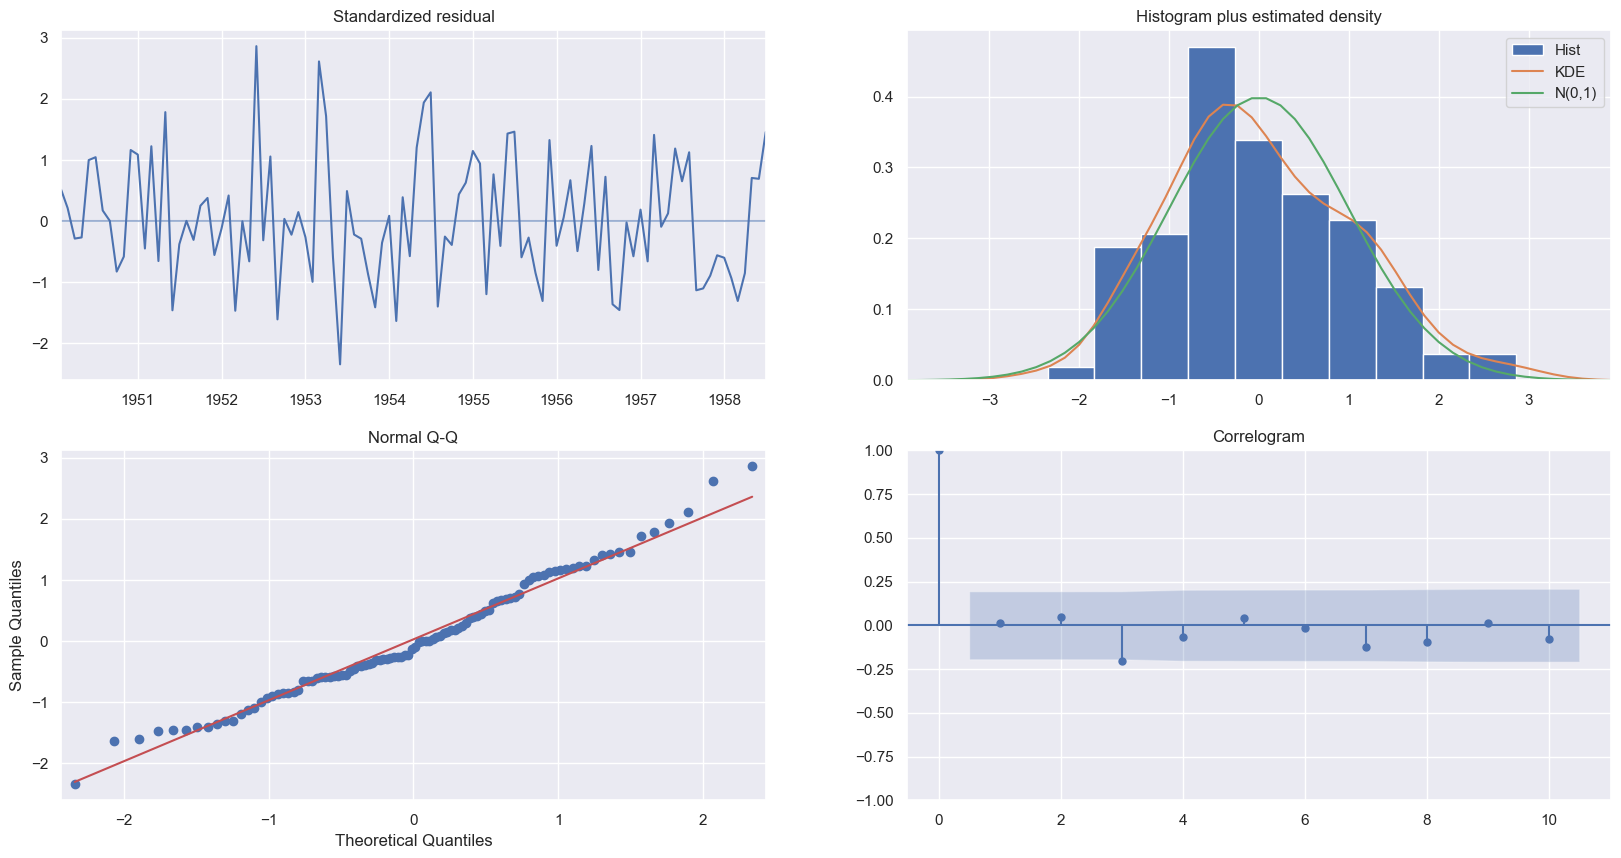

In [38]:
model.plot_diagnostics(figsize=(20,10))
plt.show()

So how to interpret the plot diagnostics?

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed. We observe that we are very close to linear.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model. Again the model here seems not to be defined from its previous lags which is a good sign.

Overall, the diagnostics indicate that it is a good fit.